In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from acquire import get_store_data
from prepare import prep_store_data


In [ ]:
df = prep_store_data(get_store_data())

In [3]:
df.head()

,sale_id,store_id,item_id,sale_amount,item_brand,item_name,item_price,store_address,store_zipcode,store_city,store_state
sale_date,,,,,,,,,,,
2013-01-01,1,1,1,13,Riceland,Riceland American Jazmine Rice,0.84,12125 Alamo Ranch Pkwy,78253,San Antonio,TX
2013-01-01,295813,3,17,26,Ducal,Ducal Refried Red Beans,1.16,2118 Fredericksburg Rdj,78201,San Antonio,TX
2013-01-01,125995,10,7,32,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,8503 NW Military Hwy,78231,San Antonio,TX
2013-01-01,314073,3,18,45,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,2118 Fredericksburg Rdj,78201,San Antonio,TX
2013-01-01,332333,3,19,34,Careone,Careone Family Comb Set - 8 Ct,0.74,2118 Fredericksburg Rdj,78201,San Antonio,TX


In [4]:
df['total_sale'] = df.sale_amount * df.item_price

In [10]:
aggregation = 'sum'
train = df[:'2016'].total_sale.resample('D').agg(aggregation)
test = df['2017':].total_sale.resample('D').agg(aggregation)

In [12]:
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training: %d' % (len(train.values)))
print('Testing: %d' % (len(test.values)))

Observations: 1826
Training: 1461
Testing: 365


In [13]:
# validation #1
4*365

1460

In [14]:
# validation #2
pd.concat([train.head(3), train.tail(3)])

sale_date
2013-01-01     73844.01
2013-01-02     73570.58
2013-01-03     78169.48
2016-12-29    113221.85
2016-12-30    120033.64
2016-12-31    128009.31
Name: total_sale, dtype: float64

In [15]:
pd.concat([test.head(3), test.tail(3)])

sale_date
2017-01-01    127262.71
2017-01-02     85329.98
2017-01-03    100389.65
2017-12-29    126541.84
2017-12-30    134903.07
2017-12-31    140905.74
Name: total_sale, dtype: float64

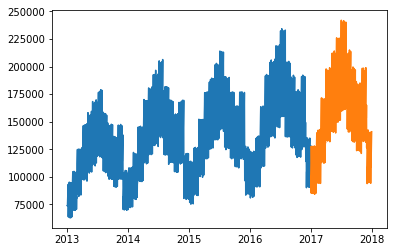

In [16]:
plt.plot(train)
plt.plot(test)
plt.show()

In [25]:
s = df.sale_amount.resample('D').agg(aggregation)
print(len(s))
train_size = int(len(s) * .66)
print(train_size)
train1, test1 = s[0:train_size], s[train_size:len(s)]

1826
1205


In [18]:
print('Observations: %d' % (len(train1.values) + len(test1.values)))
print('Training: %d' % (len(train1.values)))
print('Testing: %d' % (len(test1.values)))

Observations: 1826
Training: 1205
Testing: 621


In [19]:
.66*1826

1205.16

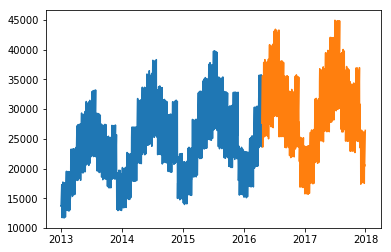

In [20]:
plt.plot(train1)
plt.plot(test1)
plt.show()

In [23]:
test1.head(3)

sale_date
2017-12-29    23535
2017-12-30    24988
2017-12-31    26420
Freq: D, Name: sale_amount, dtype: int64

In [30]:
y_hat = pd.DataFrame(dict(actual=test))

y_hat['avg_forecast'] = train.mean()

y_hat.tail()

,actual,avg_forecast
sale_date,,
2017-12-27,109151.15,136046.288159
2017-12-28,117377.49,136046.288159
2017-12-29,126541.84,136046.288159
2017-12-30,134903.07,136046.288159
2017-12-31,140905.74,136046.288159


In [31]:
y_hat.describe()

,actual,avg_forecast
count,365.000000,3.650000e+02
mean,158074.076959,1.360463e+05
std,35002.538556,8.160259e-10
min,84206.230000,1.360463e+05
25%,132144.140000,1.360463e+05
50%,159827.930000,1.360463e+05
75%,186223.680000,1.360463e+05
max,241973.150000,1.360463e+05


In [32]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()   

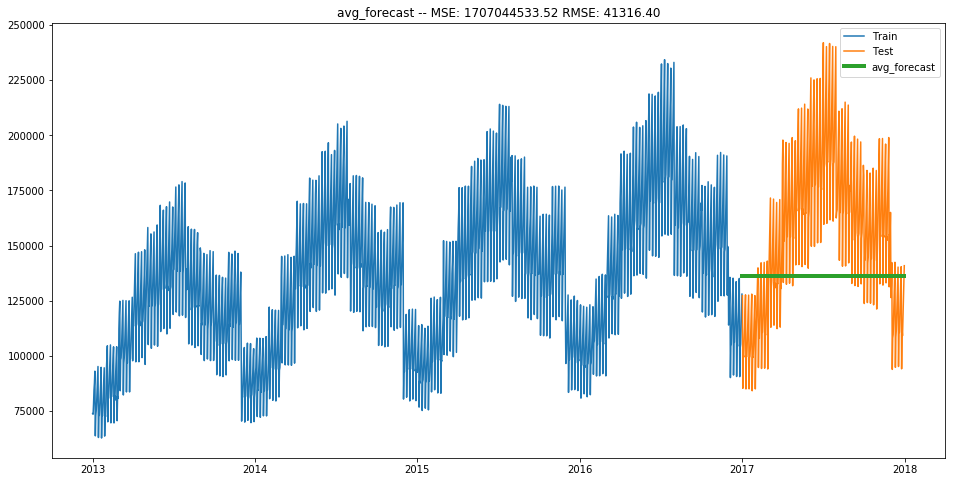

In [33]:
plot_and_eval(y_hat.avg_forecast)

In [35]:
periods = 30
train.rolling(periods).mean().iloc[-1]

114972.85499999978

In [36]:
y_hat['moving_avg_forecast'] = train.rolling(periods).mean().iloc[-1]

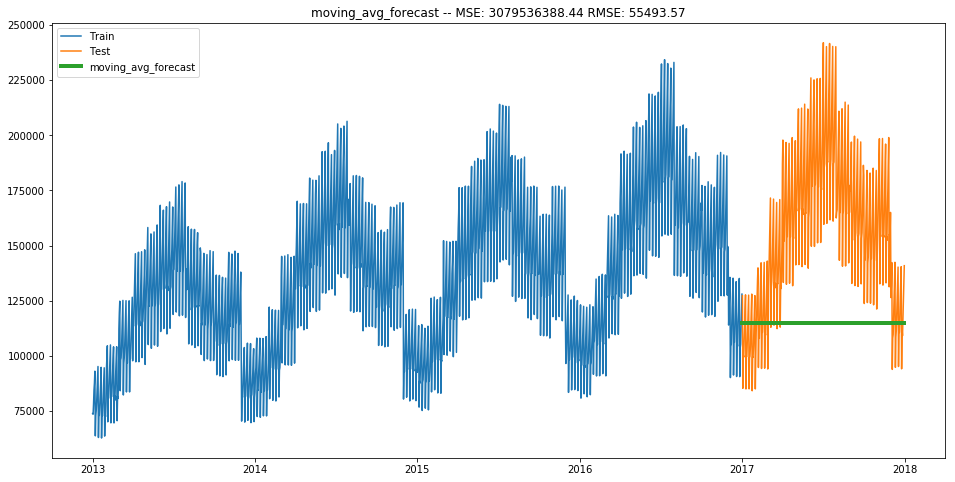

In [38]:
plot_and_eval(y_hat.moving_avg_forecast)

In [40]:
periods = [7, 28, 90, 180, 365, 720]

for pds in periods:
    y_hat[f'moving_avg_forecast_{pds}'] = train.rolling(pds).mean().iloc[-1]

    

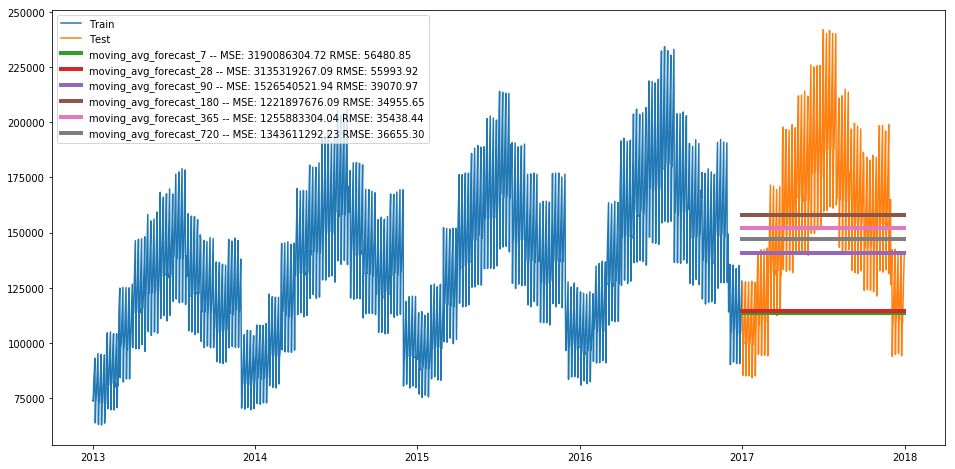

In [41]:
forecasts = [y_hat[f'moving_avg_forecast_{p}'] for p in periods]

plot_and_eval(forecasts)

In [61]:
from statsmodels.tsa.api import Holt

holt = Holt(train).fit(smoothing_level = .3, smoothing_slope = .1)
y_hat['holt_linear'] = holt.forecast(test.shape[0])

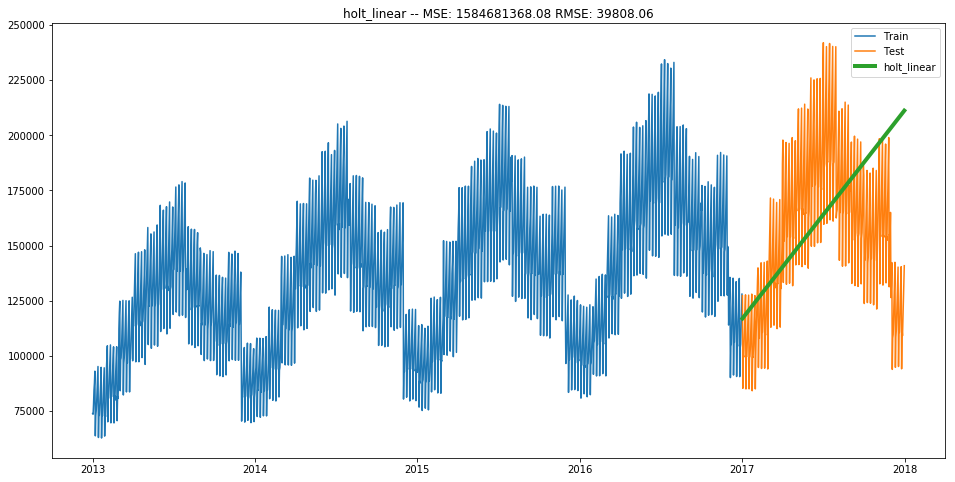

In [62]:
plot_and_eval(y_hat.holt_linear)

In [ ]:
using_last_year = train['2016'].reset_index().drop(columns='sale_date').\
    set_index(train['2016'].index+366).iloc[:-1]

In [63]:
using_last_year.head()

,total_sale
sale_date,
2017-01-01,107875.26
2017-01-02,114330.43
2017-01-03,123144.91
2017-01-04,80873.97
2017-01-05,95429.90


In [68]:
y_hat['last_year'] = using_last_year

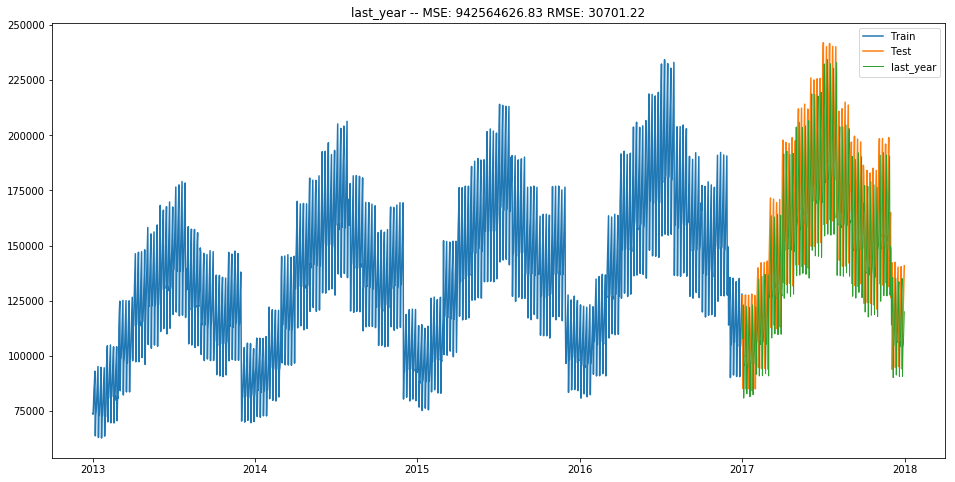

In [70]:
plot_and_eval(y_hat.last_year, linewidth=1)

In [82]:
train.diff(365).mean()

11740.794388686136

In [83]:
predictions = train['2016'] + train.diff(365).mean()

In [84]:
predictions.index = pd.date_range('20170101', periods=366)

predictions = predictions[:-1]
predictions.name = 'last year + mean'

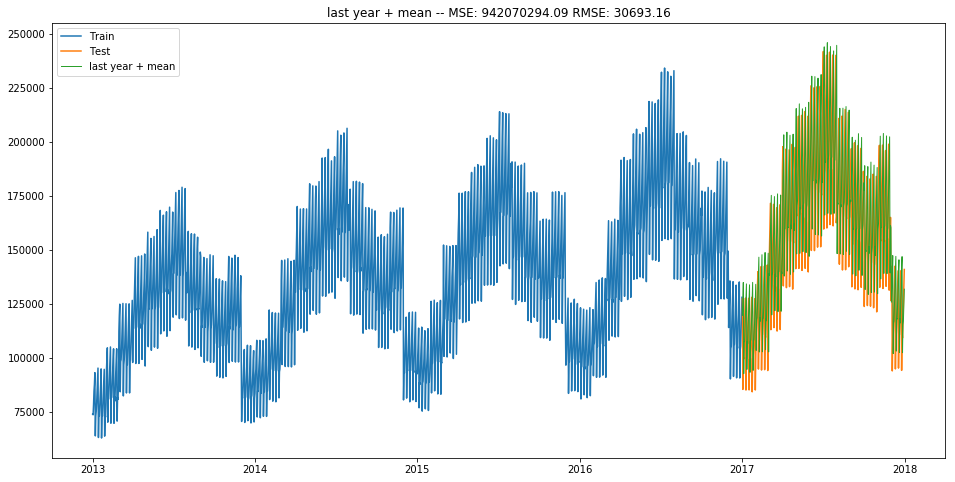

In [85]:
plot_and_eval(predictions, linewidth=1)